# 0.0 General Section

## 0.1 Import Libraries

In [1]:
import pandas  as pd
import numpy   as np
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

import datetime
import warnings
import random
import pickle
import json
import requests

from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.metrics       import mean_absolute_error, mean_squared_error

warnings.filterwarnings( 'ignore' )

## 0.2 Load Data

In [2]:
df_train_feat = pd.read_csv( '../data/train_feat.csv',  low_memory= False )
df_test_feat  = pd.read_csv( '../data/test_feat.csv',  low_memory= False )

## 0.3 Change Types

In [3]:
df_train_feat =         df_train_feat.drop( columns=['Unnamed: 0'], axis=1 )
df_train_feat['date'] = pd.to_datetime( df_train_feat['date'] )

df_test_feat =         df_test_feat.drop( columns=['Unnamed: 0'], axis=1 )
df_test_feat['date'] = pd.to_datetime( df_test_feat['date'] )

## 0.3 Functions

In [4]:
def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )

def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )

def ml_error( model_name, y, yhat ):
    mae  = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )

    return pd.DataFrame( { 'Model Name' : model_name,
                           'MAE'        : mae,
                           'MAPE'       : mape,
                           'RMSE'       : rmse
                           }, index=[0] )

def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list =  []
    mape_list = []
    rmse_list = []

    for k in range( 1, kfold+1 ) :
        list_months_cv = ['2014-07', '2014-08', '2014-09', '2014-10', '2014-11']

        if verbose:
            print(f'\nValidation Block: { k }. Month: { list_months_cv[k] } ' )

                                                                            
        # filtering dataset
        training   = x_training[ x_training['year_month'] < list_months_cv[k] ]
        validation = x_training[ x_training['year_month'] == list_months_cv[k] ]

        # training dataset
        xtraining = training.drop( ['date', 'sales', 'year_month'], axis=1 )
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales', 'year_month'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append( m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

        

    return pd.DataFrame( {  'Model Name': model_name,
                            'MAE CV'  : np.round( np.mean( mae_list ),  2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                            'MAPE CV' : np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                            'RMSE CV' : np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str )
                        }, index=[0] )



def jupyter_settings():
    %matplotlib inline
    #%pylab inline

    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24

    #display( HTML( '<style>.container { width:100% !important; }</style>') )

    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )

    sns.set()

jupyter_settings()

## 0.5 Split df_feat_train in two datasets: X_train( full ) and X_validation( last 6 months )

In [5]:

# creating full datasets: X_train and X_validation
X_train      = df_train_feat.copy() 
X_validation = df_test_feat.copy() 

# creating year_month in both datasets
X_train['year_month']      = X_train['date'].dt.strftime( '%Y-%m' )
X_validation['year_month'] = X_validation['date'].dt.strftime( '%Y-%m' )

# create x_train, y_train variables
x_train = X_train[ X_train['year_month'] <= '2014-06' ]
y_train = x_train['sales']
x_train = x_train.drop( ['date', 'sales', 'year_month'], axis=1 )

# create x_validation, y_validation variables
x_validation = X_validation[ X_validation['year_month'] == '2014-07'  ]
y_validation = x_validation['sales']
x_validation = x_validation.drop( ['date', 'sales', 'year_month'], axis=1 )



# 1.0 Machine Learning Modelling

## 1.1 Average Model

In [6]:
# create aux_df with database test + response variable (sales)
aux1          = x_validation.copy()
aux1['sales'] = y_validation.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename( columns = {'sales' :  'sales_predictions' } )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_avg = aux1['sales_predictions']

# calculate performance with response variable "sales" on original scale 
avg_model_result = ml_error( 'Average Model', np.expm1( y_validation ), np.expm1( yhat_avg ) )
avg_model_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1308.247172,NaN,1692.210075


## 1.2 Linear Regression Model - Single Performance

In [7]:
# define model
lr_model = LinearRegression().fit( x_train, y_train )

# create predictions
yhat_lr = lr_model.predict( x_validation )

# calculate performance
lr_model_result = ml_error( 'Linear Regression Model', np.expm1( y_validation ), np.expm1( yhat_lr) )
lr_model_result


,Model Name,MAE,MAPE,RMSE
0,Linear Regression Model,1908.153567,0.291914,2723.232195


### 1.2.1 Linear Regression Model - Cross Validation

In [8]:
lr_model_result_cv = cross_validation( X_train, 4, 'Linear Regression', lr_model, verbose=True )
lr_model_result_cv


Validation Block: 1. Month: 2014-08 

Validation Block: 2. Month: 2014-09 

Validation Block: 3. Month: 2014-10 

Validation Block: 4. Month: 2014-11 


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,1919.32 +/- 75.96,0.31 +/- 0.01,2658.98 +/- 108.49


## 1.3 Linear Regression Regularized Model (Lasso) - Single Performance

In [9]:
# define model
lasso_model = Lasso( alpha=0.01 ).fit( x_train, y_train )

# create predictions
yhat_lasso = lasso_model.predict( x_validation )

# calculate performance
lasso_model_result = ml_error( 'Linear Regression Regularized Model - Lasso', np.expm1( y_validation), np.expm1( yhat_lasso) )
lasso_model_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression Regularized Model - Lasso,1877.54907,0.298127,2651.24332


### 1.3.1 Linear Regression Regularized Model (Lasso) - Cross Validation

In [10]:
lasso_model_result_cv = cross_validation( X_train, 4, 'Linear Regression Regularized - Lasso', lasso_model, verbose=True )
lasso_model_result_cv


Validation Block: 1. Month: 2014-08 

Validation Block: 2. Month: 2014-09 

Validation Block: 3. Month: 2014-10 

Validation Block: 4. Month: 2014-11 


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression Regularized - Lasso,1917.05 +/- 79.42,0.31 +/- 0.01,2702.67 +/- 122.53


## 1.4 Random Forest Model - Single Performance

In [11]:
# define model
# rf_model = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train, y_train )

# create predictions
# yhat_rf = rf_model.predict( x_validation )

# calculate performance
# rf_model_result = ml_error( 'Random Forest Model', np.expm1( y_validation ), np.expm1( yhat_rf) )
# rf_model_result

### 1.4.1 Random Forest Model - Cross Validation

In [12]:
# rf_result_cv = cross_validation( X_train, 4, 'Random Forest Model', rf_model, verbose=True )
# rf_result_cv

## 1.5 XGBoost Model - Single Performance

In [13]:
# define model with default values of XGBoost's parameter
xgb_model = xgb.XGBRegressor( objective='reg:squarederror', 
                              n_estimators=100,
                              eta=0.3, 
                              max_depth=6,  
                              subsample=1,
                              colsample_bytree=1,
                              min_child_weight=1
                            ).fit( x_train, y_train )

# create predictions
yhat_xgb = xgb_model.predict( x_validation )

# calculate performance
xgb_model_result = ml_error( 'XGBoost Regressor', np.expm1( y_validation ), np.expm1( yhat_xgb) )
xgb_model_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,1484.601683,0.235888,2117.559163


### 1.5.1 XGBoost Model - Cross Validation

In [14]:
xgb_model_result_cv = cross_validation( X_train, 4, 'XGBoost Regressor', xgb_model, verbose=True )
xgb_model_result_cv


Validation Block: 1. Month: 2014-08 

Validation Block: 2. Month: 2014-09 

Validation Block: 3. Month: 2014-10 

Validation Block: 4. Month: 2014-11 


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,876.79 +/- 43.33,0.13 +/- 0.0,1247.01 +/- 59.18


## 1.6 Models Performance

### 1.6.1 Single Performance

In [15]:
models_result = pd.concat( [avg_model_result, lr_model_result, lasso_model_result, xgb_model_result] )
models_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1308.247172,NaN,1692.210075
0,Linear Regression Model,1908.153567,0.291914,2723.232195
0,Linear Regression Regularized Model - Lasso,1877.549070,0.298127,2651.243320
0,XGBoost Regressor,1484.601683,0.235888,2117.559163


### 1.6.2 Cross Validation Performance

In [16]:
models_result_cv = pd.concat( [lr_model_result_cv, lasso_model_result_cv, xgb_model_result_cv] )
models_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,1919.32 +/- 75.96,0.31 +/- 0.01,2658.98 +/- 108.49
0,Linear Regression Regularized - Lasso,1917.05 +/- 79.42,0.31 +/- 0.01,2702.67 +/- 122.53
0,XGBoost Regressor,876.79 +/- 43.33,0.13 +/- 0.0,1247.01 +/- 59.18


# 2.0 Hyperparameter Fine Tunning

## 2.1 Random Search

In [17]:
# create dict with names and values parameters
params = { 'n_estimators'     : [150, 170, 250, 300, 350],
           'eta'              : [0.1, 0.3],
           'max_depth'        : [3, 5, 9],
           'subsample'        : [0.1, 0.5, 0.7],
           'colsample_bytree' : [0.3, 0.5, 0.7],
           'min_child_weight' : [3, 8, 15]
          }

In [18]:
NUM_ITERATIONS = 10
xgb_model_result = pd.DataFrame()

for i in range( NUM_ITERATIONS ):
    # choose values for parameters randomly
    hp = { k: random.sample( v, 1)[0] for k, v in params.items() }
    print(f'Iteration n: { i+1 }. Parameters: { hp } ')

    # define model
    xgb_model = xgb.XGBRegressor( objective='reg:squarederror', 
                                  n_estimators=hp['n_estimators'],
                                  eta=hp['eta'], 
                                  max_depth=hp['max_depth'], 
                                  subsample=hp['subsample'],
                                  colsample_bytree=hp['colsample_bytree'],
                                  min_child_weight=hp['min_child_weight'],
                                ).fit( x_train, y_train )

    # create predictions
    yhat_xgb = xgb_model.predict( x_validation )

    # calculate performance
    result = cross_validation( X_train, 4, 'XGBoost Regressor', xgb_model, verbose=False )
    xgb_model_result = pd.concat( [xgb_model_result, result] )

xgb_model_result

Iteration n: 1. Parameters: {'n_estimators': 250, 'eta': 0.3, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 15} 


Iteration n: 2. Parameters: {'n_estimators': 300, 'eta': 0.1, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 3} 
Iteration n: 3. Parameters: {'n_estimators': 300, 'eta': 0.3, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 3} 
Iteration n: 4. Parameters: {'n_estimators': 250, 'eta': 0.3, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 3} 
Iteration n: 5. Parameters: {'n_estimators': 170, 'eta': 0.3, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 15} 
Iteration n: 6. Parameters: {'n_estimators': 350, 'eta': 0.3, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 8} 
Iteration n: 7. Parameters: {'n_estimators': 150, 'eta': 0.1, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 3} 
Iteration n: 8. Parameters: {'n_estimators': 350, 'eta': 0.1, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_chi

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1359.09 +/- 72.78,0.21 +/- 0.01,1947.01 +/- 102.36
0,XGBoost Regressor,1040.76 +/- 61.29,0.16 +/- 0.0,1497.12 +/- 78.22
0,XGBoost Regressor,1155.97 +/- 68.51,0.18 +/- 0.0,1644.82 +/- 90.56
0,XGBoost Regressor,987.46 +/- 52.88,0.15 +/- 0.0,1400.07 +/- 60.4
0,XGBoost Regressor,825.9 +/- 72.13,0.12 +/- 0.01,1173.6 +/- 90.53
0,XGBoost Regressor,1269.36 +/- 78.53,0.19 +/- 0.0,1800.66 +/- 110.5
0,XGBoost Regressor,1417.76 +/- 64.88,0.22 +/- 0.0,2032.87 +/- 88.9
0,XGBoost Regressor,1146.63 +/- 63.88,0.17 +/- 0.0,1636.58 +/- 82.64
0,XGBoost Regressor,1640.68 +/- 83.46,0.25 +/- 0.01,2336.73 +/- 117.87
0,XGBoost Regressor,1148.37 +/- 64.04,0.17 +/- 0.0,1627.47 +/- 76.82


## 2.2 Final Search

### 2.2.1 Create test Dataset

In [19]:
X_test = X_validation[ X_validation['year_month'] == '2014-12' ]
x_test = X_test.copy()
y_test = x_test['sales']

x_test = x_test.drop( columns=['date', 'sales', 'year_month'], axis=1 )

### 2.2.2 Execute Model with x_test

In [20]:
# selected parameters
# Iteration n: 5. Parameters: {'n_estimators': 170, 'eta': 0.3, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 15} 

# define model
xgb_model_tuned = xgb.XGBRegressor( objective='reg:squarederror', 
                                    n_estimators=170,
                                    eta=0.3, 
                                    max_depth=9,  
                                    subsample=0.7,
                                    colsample_bytree=0.3,
                                    min_child_weight=15
                                  ).fit( x_train, y_train )

# create predictions
yhat_xgb_tuned = xgb_model_tuned.predict( x_test )

# calculate performance
xgb_model_tuned_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned) )
xgb_model_tuned_result



,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,1851.199176,0.227993,2630.630631


In [21]:
mpe = mean_percentage_error( np.expm1( y_test ), np.expm1( yhat_xgb_tuned) )
mpe

-0.017917013308171803

# 3.0 Translating Model´s Performance to Business

In [22]:
# copy full test dataset
df3 = X_test.copy()

# return "sales" to original values
df3['sales']             = np.expm1( df3['sales'] )
df3['sales_predictions'] = np.expm1( yhat_xgb_tuned )

df3.head()

,store,promo,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,competition_time_month,promo2_time_week,month_cos,day_of_week_sin,day_of_week_cos,day_sin,day_cos,week_of_year_cos,date,sales,month_sin,week_of_year_sin,year_month,sales_predictions
0,1,0,2,1,-0.178457,9,2008,0,1,2014,0.705128,0.302115,1.0,0.433884,-0.900969,0.207912,0.978148,0.992709,2014-12-31,2605.0,-2.449294e-16,0.120537,2014-12,3915.542236
1,2,0,0,1,-0.290997,11,2007,1,13,2010,0.833333,0.897281,1.0,0.433884,-0.900969,0.207912,0.978148,0.992709,2014-12-31,2269.0,-2.449294e-16,0.120537,2014-12,3999.311279
2,3,0,0,1,1.889068,12,2006,1,14,2011,0.974359,0.737160,1.0,0.433884,-0.900969,0.207912,0.978148,0.992709,2014-12-31,3804.0,-2.449294e-16,0.120537,2014-12,6433.946777
3,4,0,2,3,-0.282958,9,2009,0,1,2014,0.538462,0.302115,1.0,0.433884,-0.900969,0.207912,0.978148,0.992709,2014-12-31,10152.0,-2.449294e-16,0.120537,2014-12,6641.304199
4,5,0,0,1,4.426045,4,2015,0,1,2014,-0.333333,0.302115,1.0,0.433884,-0.900969,0.207912,0.978148,0.992709,2014-12-31,1830.0,-2.449294e-16,0.120537,2014-12,4117.750488


## 3.1 Business Performance

In [23]:
# sum of predictions
df3_preds = df3[['store', 'sales_predictions']].groupby( 'store' ).sum().reset_index()

# calculate MAE and MAPE
df3_MAE = ( df3[['store', 'sales', 'sales_predictions']]
            .groupby( 'store' )
            .apply( lambda x: mean_absolute_error( x['sales'], x['sales_predictions'] ) )
            .reset_index()
            .rename( columns = { 0: 'MAE' } ) )

df3_MAPE = ( df3[['store', 'sales', 'sales_predictions']]
            .groupby( 'store' )
            .apply( lambda x: mean_absolute_percentage_error( x['sales'], x['sales_predictions'] ) )
            .reset_index()
            .rename( columns = { 0: 'MAPE' } ) )

# merge dataframes MAE and MAPE and SALES_PREDICTIONS
df3_MAE_MAPE    = pd.merge( df3_MAE, df3_MAPE, how='inner', on='store' )
df3_preds_metrs = pd.merge( df3_preds, df3_MAE_MAPE, how='inner', on='store' )

# calculate Scenarios
df3_preds_metrs['worst_scenario'] = df3_preds_metrs['sales_predictions'] - df3_preds_metrs['MAE']
df3_preds_metrs['best_scenario']  = df3_preds_metrs['sales_predictions'] + df3_preds_metrs['MAE']

df3_preds_metrs = df3_preds_metrs[['store', 'sales_predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]


In [24]:
df3_preds_metrs['sales_predictions'] = round( df3_preds_metrs['sales_predictions'], 2 )
df3_preds_metrs['worst_scenario']    = round( df3_preds_metrs['worst_scenario'], 2 )
df3_preds_metrs['best_scenario']     = round( df3_preds_metrs['best_scenario'], 2 )
df3_preds_metrs['MAE']               = round( df3_preds_metrs['MAE'], 2 )
df3_preds_metrs['MAPE']              = round( df3_preds_metrs['MAPE'] * 100, 2)




In [27]:
df3_preds_metrs.sample(5)

,store,sales_predictions,worst_scenario,best_scenario,MAE,MAPE
79,94,163524.62500,161128.45,165920.80,2396.18,27.46
236,291,178697.34375,174943.98,182450.71,3753.37,32.81
487,582,215507.21875,214111.88,216902.55,1395.33,16.44
758,911,259593.00000,257055.03,262130.97,2537.97,18.81
909,1084,193989.31250,192799.94,195178.68,1189.37,16.36


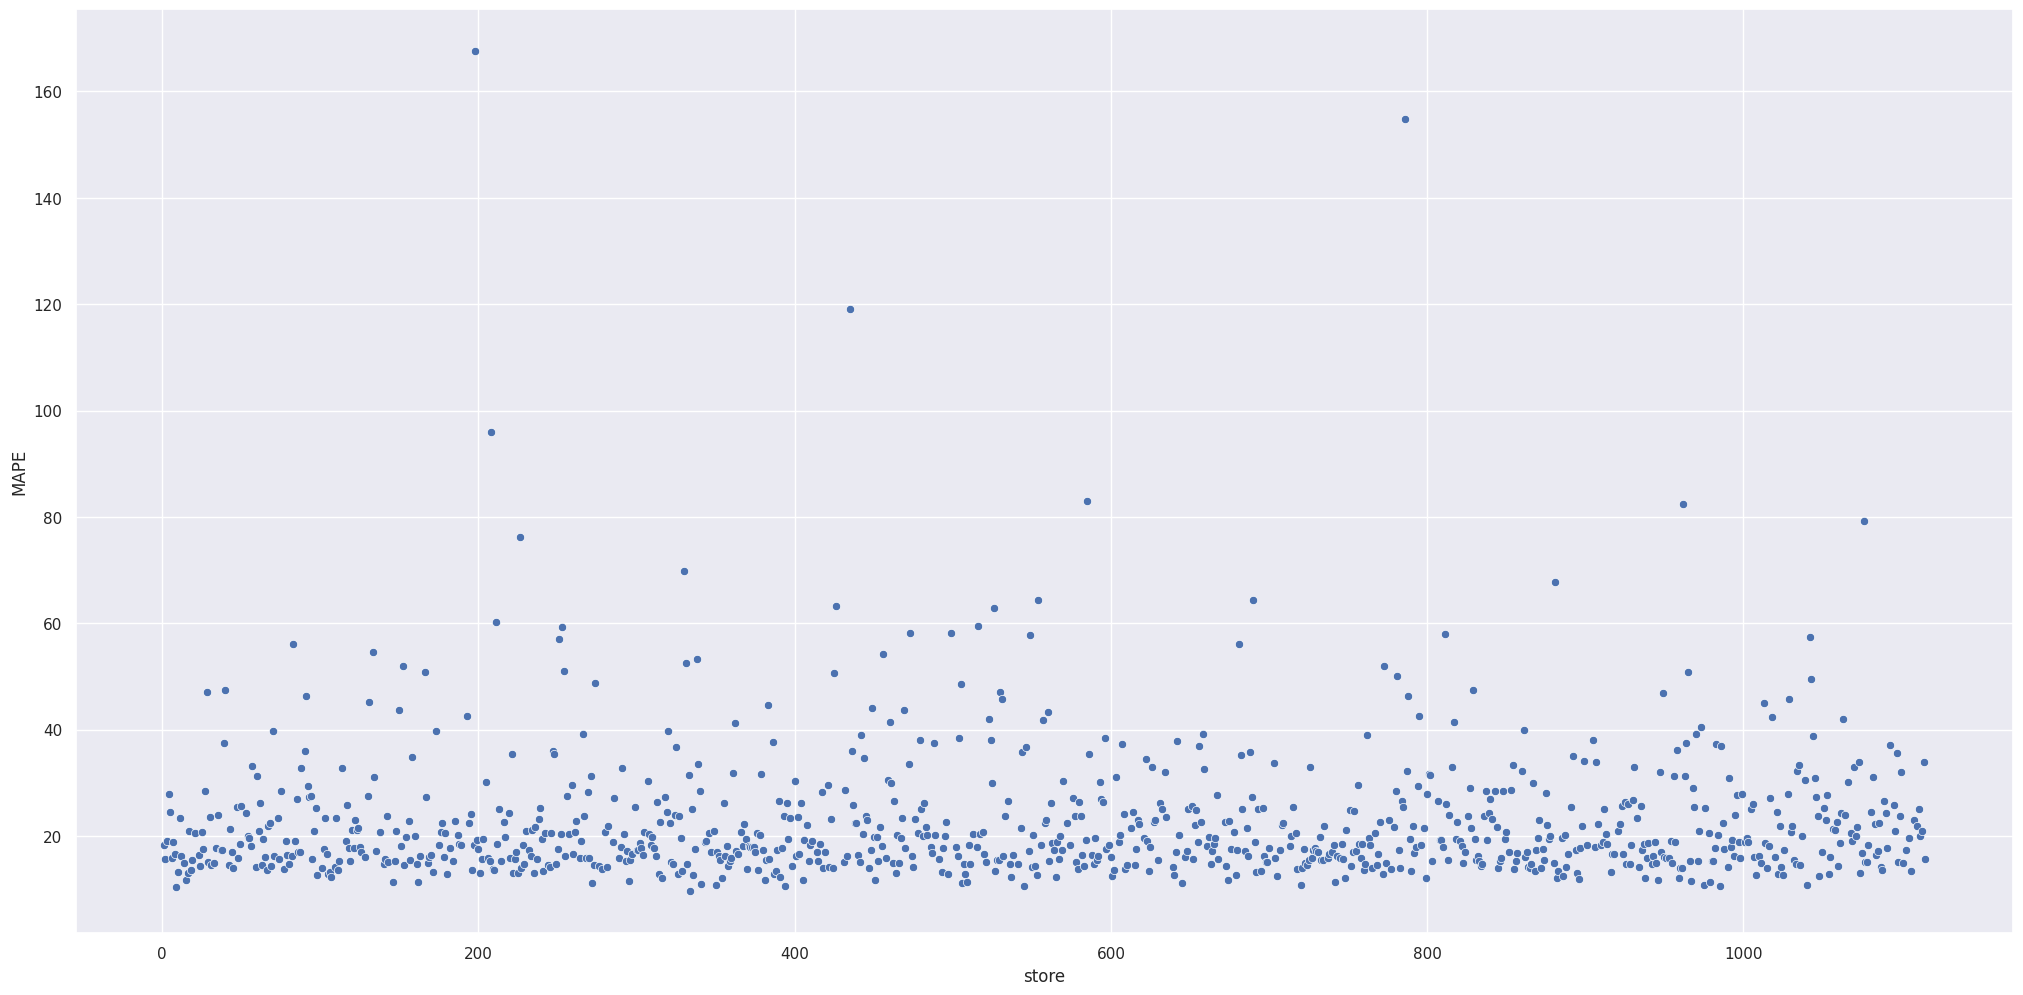

In [28]:
sns.scatterplot( x='store', y='MAPE', data=df3_preds_metrs);

## 3.2 Total Performance

In [29]:
df3_total_performance = ( df3_preds_metrs[['sales_predictions', 'worst_scenario', 'best_scenario']]
                            .apply( lambda x: np.sum(x), axis=0 )
                            .reset_index()
                            .rename( columns = {'index' : 'Scenario', 0 : 'Values' } ) 
                        )
df3_total_performance['Values'] = df3_total_performance['Values'].map( 'R$ {:,.2f}'.format )
df3_total_performance

,Scenario,Values
0,sales_predictions,"R$ 191,702,432.00"
1,worst_scenario,"R$ 189,975,726.09"
2,best_scenario,"R$ 193,429,118.37"


## 3.3 Machine Learning Performance

In [28]:
df3['error'] = df3['sales'] - df3['sales_predictions']
df3['error_rate'] = df3['sales_predictions'] / df3['sales']

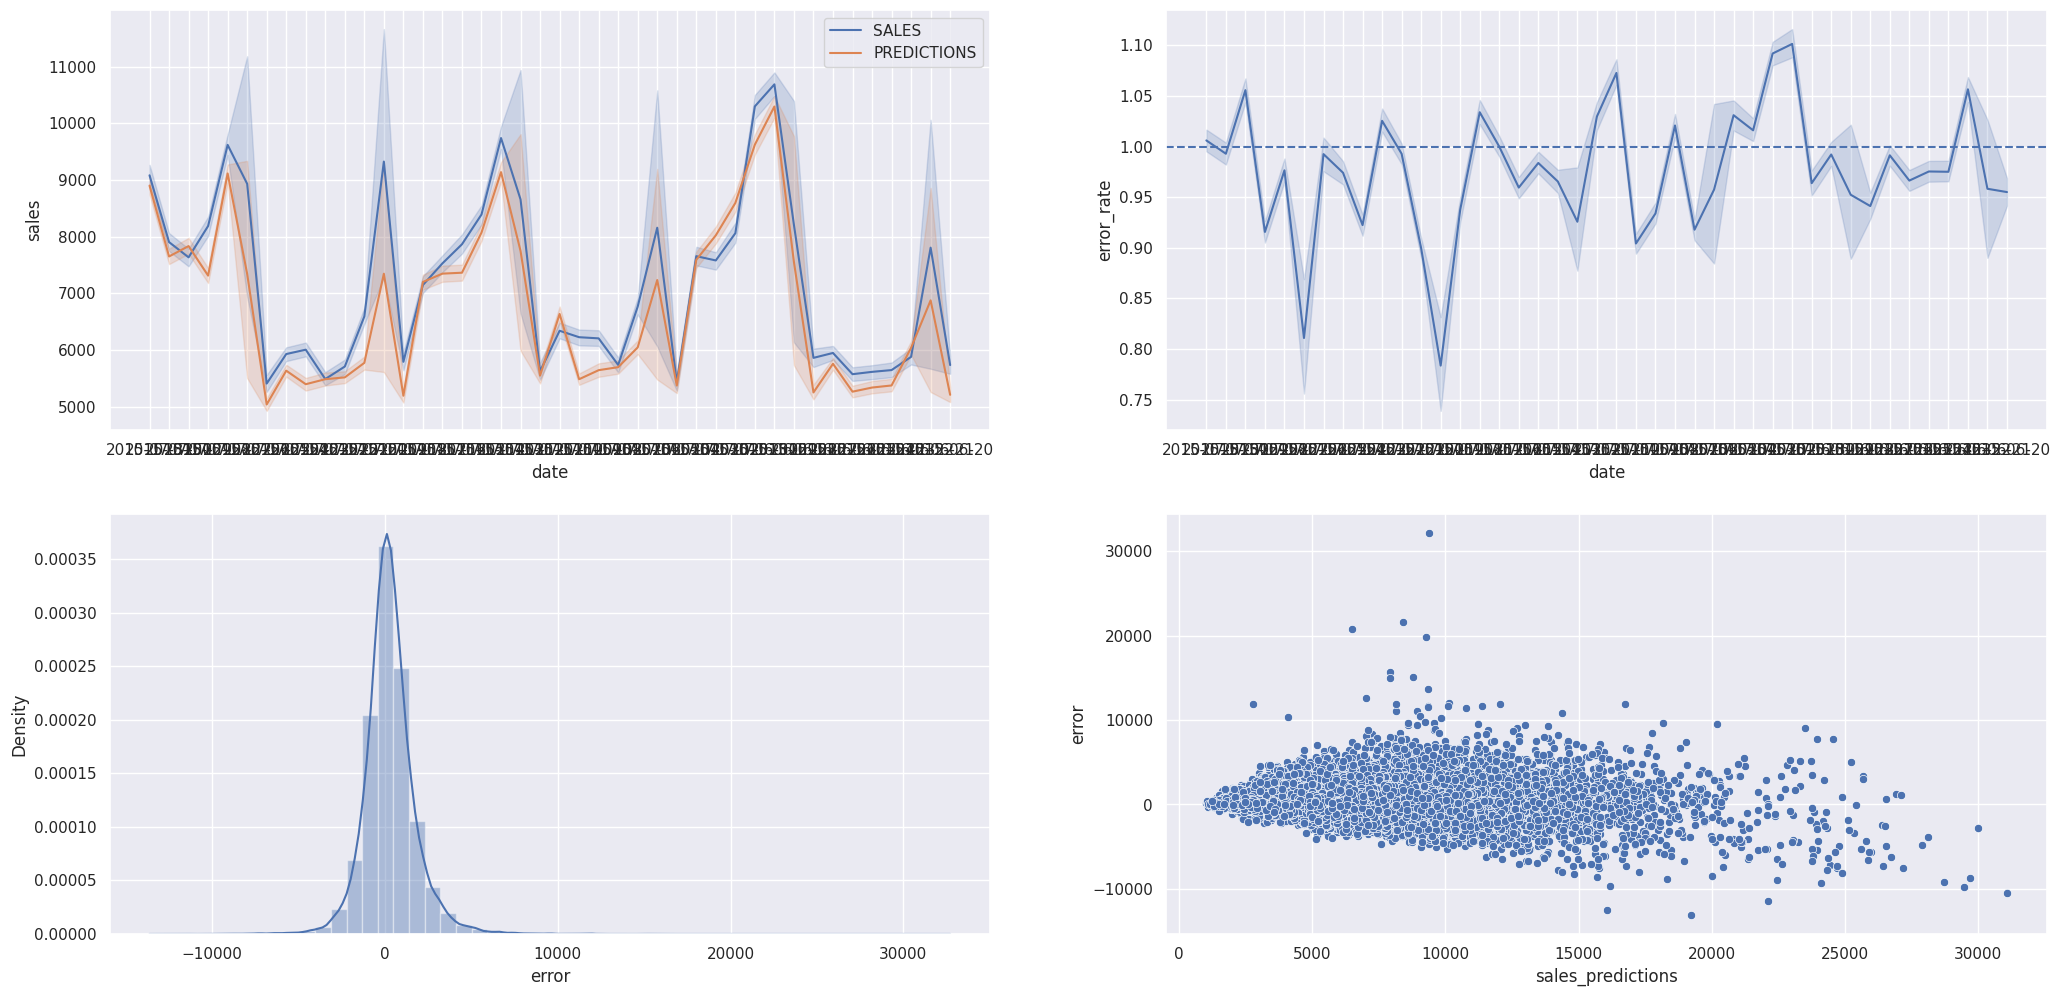

In [29]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df3, label='SALES' );
sns.lineplot( x='date', y='sales_predictions', data=df3, label='PREDICTIONS' );
             
plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df3 );
plt.axhline( 1, linestyle='--')

plt.subplot( 2, 2, 3 )
sns.distplot( df3['error'] );

plt.subplot( 2, 2, 4 )
sns.scatterplot( x='sales_predictions', y='error', data=df3 );

# 4.0 Deploy Model to Production

In [30]:
# save Trained Model
pickle.dump( xgb_model_tuned, open( '../model/model_rossmann.pkl', 'wb' ) )

## 4.1 CALL API with Production DataSet

In [11]:
# load datasets: sales, sales_predictions and store
df_sales_raw      = pd.read_csv( '../data/sales_2015.csv' )
df_sales_test_raw = pd.read_csv( '../data/sales_test_2015.csv' )
df_store_raw      = pd.read_csv( '../data/store.csv' )

# merging datasets: test + store
df_test = pd.merge( df_sales_test_raw, df_store_raw, how='left', on='Store' )
df_test = df_test.drop( columns=["Unnamed: 0", "Customers"],  axis=1 )
df_test.head()

,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [12]:
# choose store for prediction
# df_test = df_prod[  df_prod['Store'].isin( [20, 22] ) ]

# remove close day
df_test = df_test[ df_test['Open'] != 0 ]
df_test = df_test[ ~df_test['Open'].isnull() ]

#df_test['Store'].unique()


In [13]:
df_test.dtypes

Store                          int64
DayOfWeek                      int64
Date                          object
Open                           int64
Promo                          int64
StateHoliday                  object
SchoolHoliday                  int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object

In [15]:
# API CALL

# local request
url = 'http://0.0.0.0:5000/rossmann/predict'

# Render´s Server request
# url = 'https://rossmann-app-9l04.onrender.com/rossmann/predict'

header = { 'Content-type' : 'application/json' }


response = requests.post( url, data=data, headers=header )
print(f'Status Code: { response.status_code } ' )

Status Code: 200 


In [16]:
# return dataframe with predictions
d1 = pd.DataFrame( response.json(), columns=response.json()[0].keys() )
d2 = d1[['store', 'predictions']].groupby( 'store' ).sum().reset_index()
d2.head()

,store,predictions
0,1,8.628253e+05
1,2,9.072326e+05
2,3,1.213118e+06
3,4,1.516595e+06
4,5,8.431897e+05


In [22]:

#d2['predictions'] = round( d2['predictions'] , 2) 

#d2[['store', 'predictions']].sort_values( 'predictions', ascending=False).head(100)



789970.05

In [42]:
#sales_prediction = d2[d2['store'] == 15]['predictions'].sum()
#sales = df_sales_raw[df_sales_raw['Store'] == 15]['Sales'].sum()

sales_prediction = d2['predictions'].sum()
sales = df_sales_raw['Sales'].sum()

print(f'sales:  {sales} ')
print(f'prediction: {sales} ')

print(f'percentual: { round(100-(sales_prediction/sales*100),2) } ')

sales:  1389499643 
prediction: 1389499643 
percentual: 3.37 


In [30]:


d1[['store', 'date', 'predictions']].to_csv('../data/sales_predictions_2015.csv')